# Convolutive neural network

## Principe de la convolution

Le CNN est un réseau de neurones qui utilise une méthode de convolution au lieu d'une formule de somme pondérée.
Ceci est particulièrement adapté pour les images. La convolution se fait via un kernel : une matrice de poids, par exemple de 3x3.

On applique ce kernel sur chaque zone de l'image, en le décalant d'un certain nombre de pixel (pas = stride, par défaut 1 pixel).
A chaque fois, on réalise une multiplication terme a terme entre les valeurs de pixel de l'image et les poids du kernel.
On réalise ensuite la somme de la matrice obtenue.

Il est possible d'ajouter du padding à l'image, afin d'obtenir une image de la même taille que l'image d'origine :
* padding = "same" pour garder la même taille
* padding = "valid" pour ne pas utiliser de padding

Un neurone convolutif va générer une couche de convolution, à partir de ses paramètres contenus dans le kernel ainsi qu'un biais.
On peut aussi avoir des kernel de 3 dimensions, dans le cas ou on veut réaliser la convolution de plusieurs couches (par exemple
une image RGB).
Un neurone convolutif a toujours une fonction d'activation.

## Utilisation des neurones convolutifs

La mise à jour des paramètres, les epoch et les batchs vont fonctionner de la même façon que dans les CNN. En pratique, un réseau convolutif aura
la structure suivante:
* Des couches de convolution (autant de neurones que de matrices de convolution souhaitées)
* Une couche de pooling :
* Une couche de drop-off

Ces 3 étapes étant répétées plusieurs fois, ce qui a pour résultat une diminution de la superficie de l'image mais une augmentation en profondeur
de l'information. Au bout d'un moment, l'image devient trop petite pour faire de la convolution. A ce moment la, on va tout mettre à plat et
finir l'analyse par un DNN :

* Flat layer: visant à aplatir toutes les couches de convolution de la dernière étape
* Une ou plusieurs couches de neurones completement connectés (dense)
* Une couche finale avec autant de neurones que de classes (pour une classification)

### Pooling

En général on réalise du Max pooling mais on peut aussi faire du Average pooling. Cela consiste a prendre la valeur maximale
(ou la moyenne) dans la matrice de convolution de l'image, pour une fenetre de 2x2 (par exemple). On fait ensuite glisser cette fenetre sur toute
la surface de la matrice de convolution. Le résultat est une réduction de la taille de l'image : avec une fenetre de 2x2 elle sera divisée par 2 par exemple.

Il est possible de personnaliser le padding, le stride et la taille de la fenetre.

### Drop-off

## Application 1 : MNIST

### Mise en place

In [3]:
import numpy as np
import tensorflow as tf
import keras

import matplotlib.pyplot as plt
import pandas as pd
import os,sys
from sklearn.model_selection import train_test_split

In [4]:
data_path = "dataset/winequality/winequality-red.csv"
data = pd.read_csv(data_path, sep=';')

In [5]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [6]:
print('Missing Data :', data.isna().sum().sum(), 'Shape is : ', data.shape)

Missing Data : 0 Shape is :  (1599, 12)


La variable cible est 'quality'.

### Préparation des données

In [7]:
X = data.drop('quality', axis=1)
y = data['quality']

In [8]:
# Normalisation min-max (x-xmin)/(xmax-xmin)
Xmin = X.min()
Xmax = X.max()
X_n = (X-X.min())/(Xmax-Xmin)
X_n = np.array(X_n)
y = np.array(y)

In [9]:
# Normalisation centrée réduite
Xmean = X.mean()
Xstd = X.std()
X_n = (X-Xmean)/Xstd
X_n = np.array(X_n)
y = np.array(y)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_n, y, test_size=0.2, random_state=42)
print('X_train : ', X_train.shape, 'y_train : ', y_train.shape)
print('X_test : ', X_test.shape, 'y_test : ', y_test.shape)

X_train :  (1279, 11) y_train :  (1279,)
X_test :  (320, 11) y_test :  (320,)


In [11]:
X_train.shape

(1279, 11)

### Définition du Modèle

In [12]:
def get_model_v1(shape):
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape, name='InputLayer'))
    model.add(keras.layers.Dense(64, activation='relu', name='Dense_n1'))
    model.add(keras.layers.Dense(64, activation='relu', name='Dense_n2'))
    model.add(keras.layers.Dense(1, name='Output'))
    model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae', 'mse'])
    return model

### Entrainement du modèle

In [13]:
model = get_model_v1((X_train.shape[1],))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Dense_n1 (Dense)                     │ (None, 64)                  │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_n2 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,993 (19.50 KB)

 Trainable params: 4,993 (19.50 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
os.makedirs('./models', mode=0o750, exist_ok = True)
save_dir = './models/wine_best_model.keras'

savemodel_callback = keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose = 0, save_best_only = True)

In [15]:
history = model.fit(X_train, y_train, epochs = 100, batch_size = 10, validation_data = (X_test, y_test), callbacks = [savemodel_callback])

Epoch 1/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 19.2679 - mae: 3.9476 - mse: 19.2679 - val_loss: 2.3553 - val_mae: 1.1956 - val_mse: 2.3553
Epoch 2/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - loss: 2.1202 - mae: 1.1444 - mse: 2.1202 - val_loss: 1.3254 - val_mae: 0.9071 - val_mse: 1.3254
Epoch 3/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - loss: 1.2851 - mae: 0.8899 - mse: 1.2851 - val_loss: 0.8804 - val_mae: 0.7427 - val_mse: 0.8804
Epoch 4/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - loss: 0.8822 - mae: 0.7242 - mse: 0.8822 - val_loss: 0.6711 - val_mae: 0.6582 - val_mse: 0.6711
Epoch 5/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 0.6809 - mae: 0.6218 - mse: 0.6809 - val_loss: 0.6435 - val_mae: 0.6477 - val_mse: 0.6435
Epoch 6/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 0.5705 - mae: 0.5896 - mse: 0.5705 - val_loss: 0.6203 - val_mae: 0.6352 - val_mse: 0.6203
Epoch 7/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - loss: 0.5237 - mae: 0.556

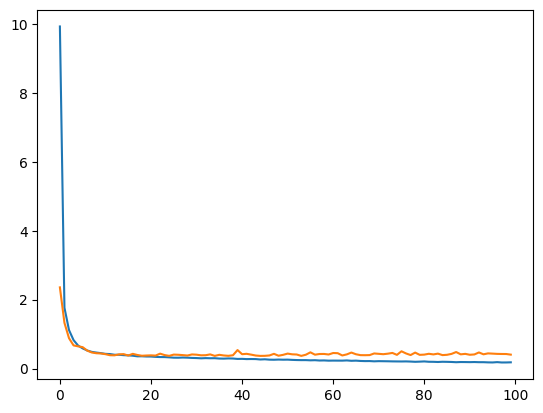

In [16]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])

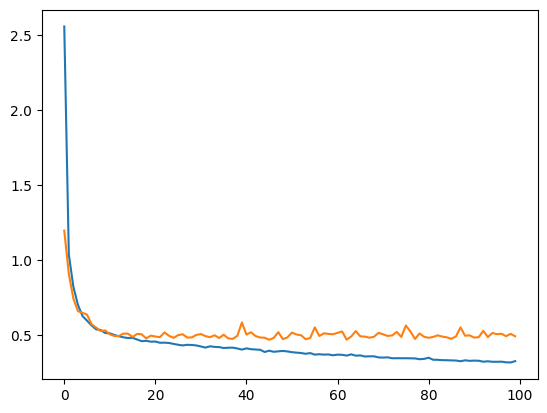

In [17]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])

## Application 2 : MNIST

Chargement du dataset à partir de keras

On utilise un DNN avec autant de neurones de sorties que de classes (9). La dernière fonction d'activation est une softmax qui permet d'avoir une probabilité.

On utilise ensuite une fonction argmax qui permet d'avoir le numéro de la classe avec la plus haute proba.

In [18]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data(path="mnist.npz")


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
(60000, 28, 28)


In [19]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


### Normalisation

Ici on utilise la minmax


In [23]:
print(x_train.min(), x_train.max())
xmax = x_train.max()
x_train_n = x_train/xmax
x_test_n = x_test/xmax
print(x_train_n.min(), x_train_n.max())

0 255
0.0 1.0


### Créer le modèle

In [25]:
def get_model_v2(shape):
    hidden1 = 100
    hidden2 = 100
    model = keras.models.Sequential([
        keras.layers.Input(shape, name='InputLayer'),
        keras.layers.Flatten(),
        keras.layers.Dense(hidden1, activation='relu', name='Dense_n1'),
        keras.layers.Dense(hidden2, activation='relu', name='Dense_n2'),
        keras.layers.Dense(10, activation= 'softmax', name='Output')])
    
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    return model

In [26]:
size = (x_train.shape[1], x_train.shape[2])
model = get_model_v2(size)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_n1 (Dense)                     │ (None, 100)                 │          78,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_n2 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 89,610 (350.04 KB)

 Trainable params: 89,610 (350.04 KB)

 Non-trainable params: 0 (0.00 B)